---
# Most Exciting Input generator
---

In [1]:
import numpy as np
from example_models import CIFAR_model, show_image, show_image_grid

import sys
sys.path.append('..')

# First build and train your models

In [3]:
model = CIFAR_model
load = False

model1 = model(name="cifar_model1", load=load)
model2 = model(name="cifar_model2", load=load)

if not load:
    model1.train(epochs=5)
    model2.train(epochs=5)
model1.eval()
model2.eval()
model1.save()
model2.save()

Epoch 1/5
391/391 [==============================] - 10s 23ms/step - loss: 1.8580 - val_loss: 1.5531
Epoch 2/5
391/391 [==============================] - 10s 26ms/step - loss: 1.6437 - val_loss: 1.6078
Epoch 3/5
391/391 [==============================] - 10s 24ms/step - loss: 1.7680 - val_loss: 1.8766
Epoch 4/5
391/391 [==============================] - 9s 23ms/step - loss: 2.1871 - val_loss: 2.0366
Epoch 5/5
391/391 [==============================] - 10s 24ms/step - loss: 2.5983 - val_loss: 1.8896
Epoch 1/5
391/391 [==============================] - 12s 28ms/step - loss: 1.8442 - val_loss: 1.5581
Epoch 2/5
391/391 [==============================] - 10s 24ms/step - loss: 1.6412 - val_loss: 1.5045
Epoch 3/5
391/391 [==============================] - 10s 25ms/step - loss: 1.6161 - val_loss: 1.4961
Epoch 4/5
391/391 [==============================] - 10s 25ms/step - loss: 1.5967 - val_loss: 1.4832
Epoch 5/5
391/391 [==============================] - 10s 26ms/step - loss: 1.6255 - val_loss

# Import and instantiate MEI

In [4]:
import src.mei as mei
Mei = mei.MEI(models=[model1, model2], shape=(3, 32, 32))

# Generate *most exciting input*

100%|██████████| 1000/1000 [00:22<00:00, 43.81it/s]


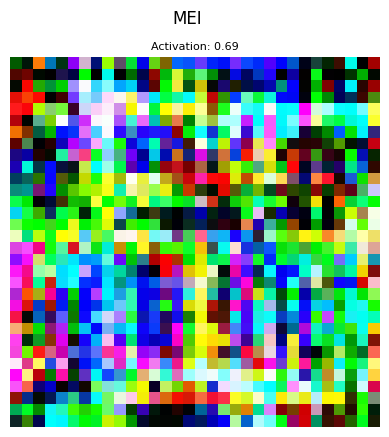

In [5]:
meip = Mei.generate(0,
                    iter_n=1000,           # number of iterations
                    start_sigma=1.5,
                    end_sigma=0.01,
                    start_step_size=3.0,
                    end_step_size=0.125,
                    precond=0,            # strength of gradient preconditioning filter falloff
                    step_gain=0.1,        # scaling of gradient steps
                    jitter=0,             #size of translational jittering
                    blur=True,
                    norm=-1,              # norm adjustment after step, negative to turn off
                    train_norm=-1,        # norm adjustment during step, negative to turn off
                    clip=True)            # Whether to clip the range of the image to be in valid range
show_image(np.transpose(meip.image, (1, 2, 0)), text="MEI", activation=meip.activation)

In [6]:
#list neuron query for multiple dimension output
meip_complex = Mei.generate([2]) # for 2 dimensions would be [0,1] for example

#no neuron query to generate for all neurons
#meip_all = Mei.generate()

#custom neuron query
meip_custom = Mei.generate(lambda index: index[-1]%2==0)

100%|██████████| 1000/1000 [00:20<00:00, 49.85it/s]


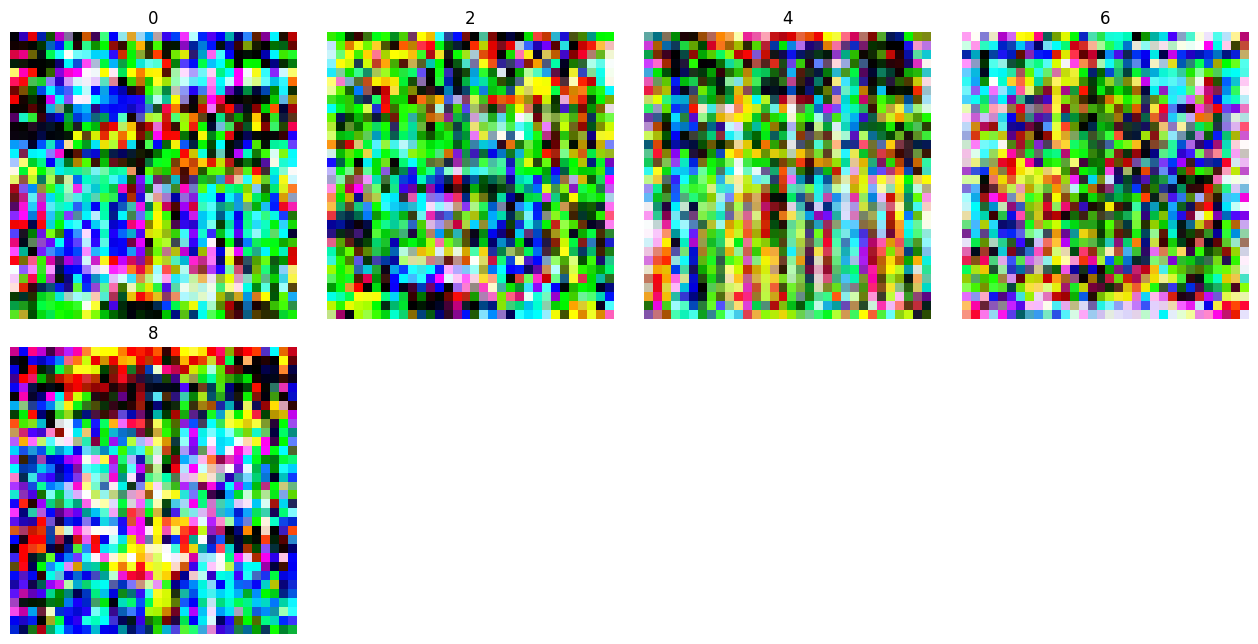

In [7]:
show_image_grid(
    [np.transpose(m.image, (1, 2, 0)) for m in meip_custom],
    texts=[f"{i}" for i in range(0, 10, 2)],
    activations=[m.activation for m in meip_custom])

# Generate gradient receptive field

100%|██████████| 1/1 [00:00<00:00, 53.20it/s]


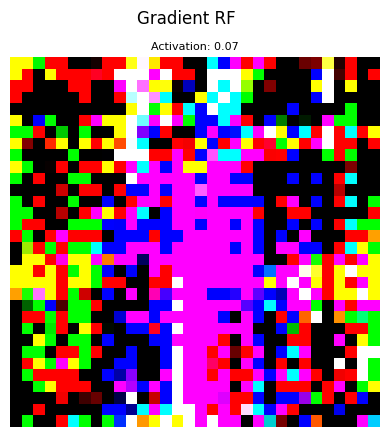

In [8]:
gradrf = Mei.gradient_rf(0,
                         iter_n=1000,
                         start_sigma=1.5,
                         end_sigma=0.01,
                         start_step_size=3.0,
                         end_step_size=0.125,
                         precond=0,
                         step_gain=0.1,
                         jitter=0,
                         blur=True,
                         norm=-1,
                         train_norm=-1,
                         clip=True)
show_image(np.transpose(gradrf.image, (1, 2, 0)), text="Gradient RF", activation=gradrf.activation)

# Find most excitatory samples from dataset

100%|██████████| 391/391 [18:02<00:00,  2.77s/it]


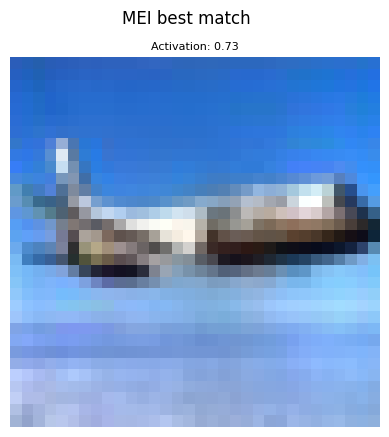

In [10]:
meip_best_match_activation, meip_best_match_image = meip.best_match(model1.train_dataset)
show_image(np.transpose(meip_best_match_image, (1, 2, 0)), text="MEI best match", activation=meip_best_match_activation)

# Compare original and *masked/shifted* responses

100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


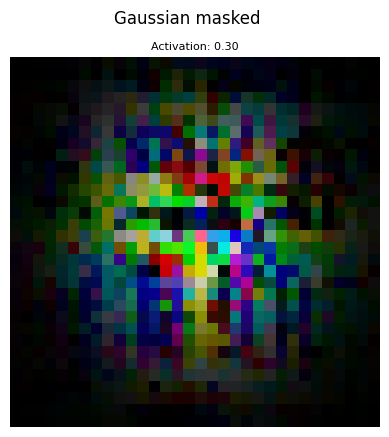

In [11]:
# Gaussian mask

gaussian_masked_resp, gaussian_masked_image = meip.masked_responses(mask="gaussian", factor=4)
show_image(np.transpose(gaussian_masked_image, (1, 2, 0)), text="Gaussian masked", activation=gaussian_masked_resp)

100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


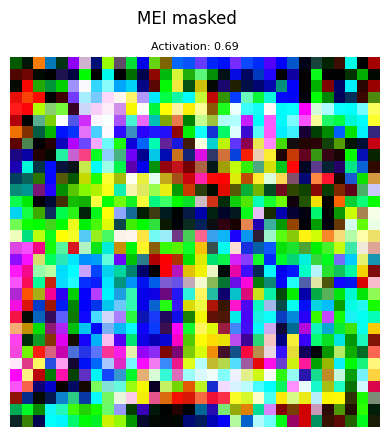

In [12]:
# MEI mask

mei_masked_resp, mei_masked_image = \
    meip.masked_responses(mask="mei",
                         delta_thr=0.4,     # threshold on the difference from mean
                         size_thr=75,       # threshold for size of blobs
                         expansion_sigma=2, # mask size expansion sigma
                         expansion_thr=0.4, # mask size expansion threshold
                         filter_sigma=3)    # sigma for final gaussian blur
show_image(np.transpose(mei_masked_image, (1, 2, 0)), text="MEI masked", activation=mei_masked_resp)

100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


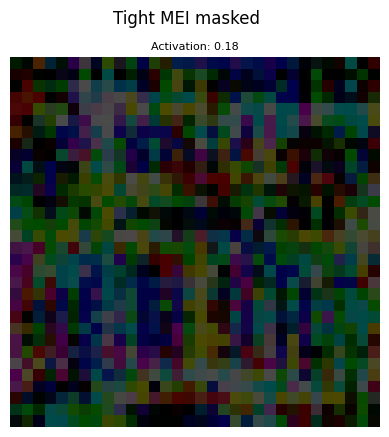

In [13]:
# Tight MEI mask

t_mei_masked_resp, t_mei_masked_image = \
    meip.masked_responses(mask="mei_tight",
                          stdev_size_thr=1,           #fraction of standard dev threshold for size of blobs
                          filter_sigma=100,             #sigma for final gaussian blur
                          target_reduction_ratio=0.9) #reduction ratio to achieve for tightening the mask
show_image(np.transpose(t_mei_masked_image, (1, 2, 0)), text="Tight MEI masked", activation=t_mei_masked_resp)

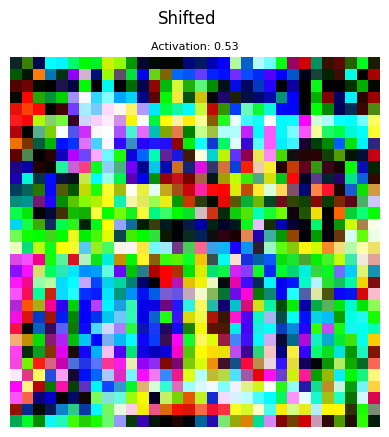

In [14]:
# Shifted

shifted_resp, shifted_image = meip.shifted_response(x_shift=1, y_shift=3)
show_image(np.transpose(shifted_image, (1, 2, 0)), text="Shifted", activation=shifted_resp)

# Create Gabor stimuli and find most excitatory ones

In [15]:
gabor = mei.Gabor(models=[model1, model2], shape=(3, 32, 32))

In [16]:
# only for greyscale images due to computational efficiency

#best_gabor = gabor.best_gabor(0)
#show_image(np.transpose(best_gabor.image, (1, 2, 0)), text="Best Gabor", activation=best_gabor.activation)

# Find optimal Gabor stimuli

100%|██████████| 5/5 [27:21<00:00, 328.22s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


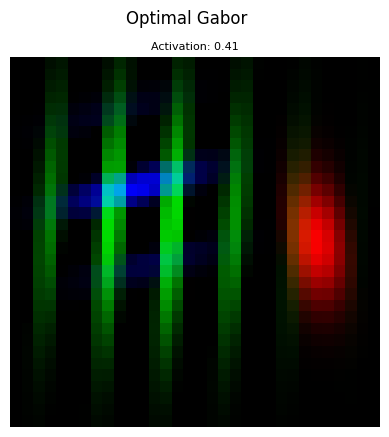

In [17]:
optimal_gabor = gabor.optimal_gabor(0)
show_image(np.transpose(optimal_gabor.image, (1, 2, 0)), text="Optimal Gabor", activation=optimal_gabor.activation)

# Compute spatial frequency

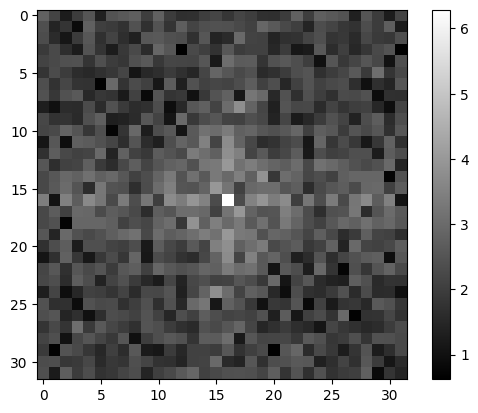

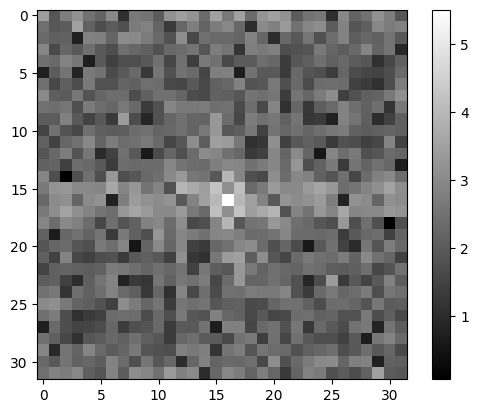

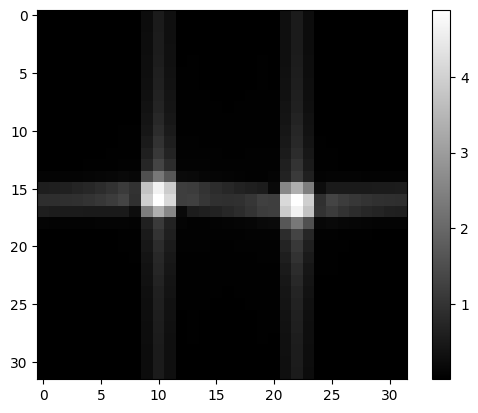

In [18]:
freq_cols_mei, freq_rows_mei, magnitude_spectrum_mei = meip.spatial_frequency()

freq_cols_gradrf, freq_rows_gradrf, magnitude_spectrum_gradrf = gradrf.spatial_frequency()

freq_cols_optimal_gabor, freq_rows_optimal_gabor, magnitude_spectrum_optimal_gabor = optimal_gabor.spatial_frequency()